In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), ".."), ".."))
sys.path.append(parent_dir)
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from collections import Counter
from data_generation.models.tech_substitution import TechnologySubstitution
from data_generation.models.tech_substitution import TechSubNumericalSolver
from data_generation.models.general_ode_solver import FitzHughNagumoModel
from data_generation.models.general_ode_solver import GeneralODENumericalSolver
from data_generation.simulations.grid import Grid, fractional_transformation, logistic_transformation
from data_generation.simulations.simulator import Simulator, run_and_store_simulations
from data_generation.simulations.stopping_criteria import calculate_entropy, create_stopping_by_entropy_threshold_criteria, entropy_of_uniform_distribution_over_percentage
from data_generation.visualization.create_plots import plot_2D_vector_field_over_grid

In [2]:
bounds = [(0, np.inf), (0, np.inf)]
transformations = [fractional_transformation(3), fractional_transformation(3)]
model = TechnologySubstitution()
num_solver = TechSubNumericalSolver(model)
control = np.array(1)
resolution = [10, 10]
num_samples_per_cell = 5
num_steps = 30
max_steps = 100
delta_t = 1

In [3]:
n = np.prod(resolution)
percentage = 0.7


In [4]:
grid = Grid(bounds, resolution, transformations)
simulator = Simulator(grid, model, num_solver)
threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
threshold

np.float64(6.129283016944967)

In [5]:
data, cell_indices = simulator.simulate_with_stopping_criteria(control, 
                                          delta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

Stopped at entropy: 6.077503767794978 <= 6.129283016944967 (threshold)
Simulation complete:
- 500 samples × 30 timesteps = 15000 total rows
- State dimensions: 2
- Control dimensions: 1


In [6]:
cell_data = cell_indices.reshape(-1, cell_indices.shape[-1])
entropy_value, unique, probabilities = calculate_entropy(cell_data, base= 2)

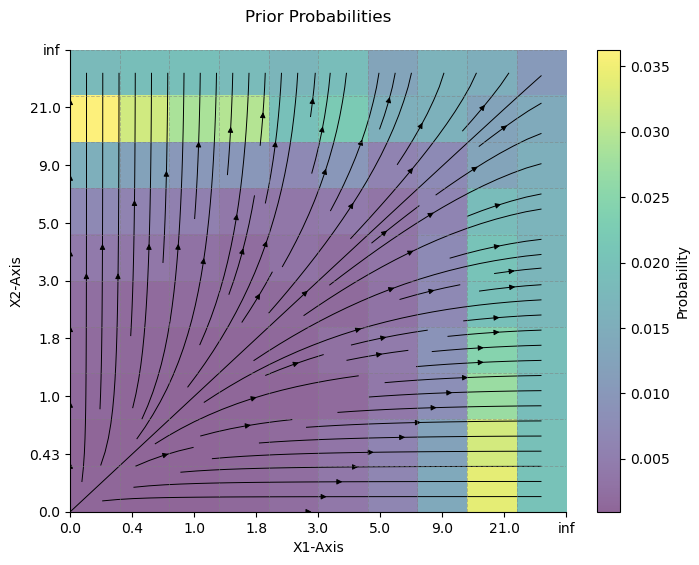

In [7]:
# Reshape probabilities to match the grid resolution
probabilities_reshaped = probabilities.reshape(resolution)

# Create a plot
fig, axes = plt.subplots(figsize=(8, 6))
# Adjust the aspect ratio to match the grid resolution
extent = [0, 1, 0, 1]
im = axes.imshow(probabilities_reshaped, cmap='viridis', origin='lower', extent=extent, aspect='auto', alpha=0.6)
fig.colorbar(im, ax=axes, label='Probability')
#axes.title('Grid Probability Distribution')

plot_2D_vector_field_over_grid(grid, num_solver, control, display_vectorfield=False, resolution=21, title= 'Prior Probabilities', ax= axes, streamplot_colour='black', vectorfield_colour='red')

plt.show()